## Introduction/Business Problem
The success of opening a new restaurant depends on several factors: demand, class, quality of food, competition, and more. In most cases, a restaurant’s location plays an essential role for its success. Therefore, it is very important to determine the most strategic location for establishment in order to maximize the profit.
 
A client seeks to establish a new Mexican restaurant in a Toronto neighborhood. There are not that many Mexican restaurants in the city, which means that the market can support a new establishment in this category. Which neighbourhood would appear to be an optimal and most strategic location for the business operations?

## Data
The Foursquare API will be used to explore neighborhoods in Toronto, more specifically, we will be using the explore function to get the most common venue categories in each neighborhood.

Neighbourhood names, alongside their corresponding boroughs and postal codes, scraped from Wikipedia: (https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050)

The Toronto's census data for its social demographic characteristics will be distilled from Toronto's Neighborhood Profile (http://bit.ly/2KpLCST).

Geographical coordinates of each neighbourhood: (https://cocl.us/Geospatial_data)

## Import Libraries 

In [1]:
import pandas as pd
import numpy as np
import requests

## Load and store the data

In [2]:
# load total population of each Toronto neighbourhood
pop_path = pd.read_csv('https://raw.githubusercontent.com/AminAli-DS/Mexican-Restaurant-In-Toronto/main/Toronto%20Population.csv')
df_pop = pd.DataFrame(pop_path)

# load population of Mexicans in Toronto neighbourhoods
ethnic_path = pd.read_csv('https://raw.githubusercontent.com/AminAli-DS/Mexican-Restaurant-In-Toronto/main/Mexican%20Population%20in%20Toronto.csv')
df_ethnic = pd.DataFrame(ethnic_path)

# load household income of each Toronto neighbourhood
income_path = pd.read_csv('https://raw.githubusercontent.com/AminAli-DS/Mexican-Restaurant-In-Toronto/main/Average%20After-Tax%20Household%20Income.csv')
df_income = pd.DataFrame(income_path)


print("{}, {}, {}".format(df_ethnic.shape[1], df_pop.shape[1], df_income.shape[1]))

3, 3, 3


## Merge the three dataframes

In [3]:
from functools import reduce
dfs = [df_pop, df_ethnic, df_income]
df_census = reduce(lambda df_left,df_right: pd.merge(df_left, df_right, 
                                              left_index=True, right_index=True, 
                                              how='inner'), dfs)
df_census.drop(['Neighbourhood_x'],  axis=1, inplace=True)
df_census.drop(['Neighbourhood_y'],  axis=1, inplace=True)
df_census.rename(columns={'Average Income of Household': 'Household Income'}, inplace=True)

column_names = ["Neighbourhood ID", "Neighbourhood ", "Toronto Population", "Mexican Population", "Household Income"]

df_census = df_census.reindex(columns=column_names)

df_census = df_census.sort_values('Neighbourhood ID')

df_census.drop(['Neighbourhood ID'], axis=1, inplace=True)
df_census.rename(columns={'Neighbourhood ': 'Neighbourhood'}, inplace=True)

df_census

,Neighbourhood,Toronto Population,Mexican Population,Household Income
124,West Humber-Clairville,33312,45,426156
81,Mount Olive-Silverstone-Jamestown,32954,115,360648
117,Thistletown-Beaumond Heights,10360,105,140050
101,Rexdale-Kipling,10529,110,134305
38,Elms-Old Rexdale,9456,25,123119
...,...,...,...,...
123,West Hill,27392,140,316750
132,Woburn,53485,90,629030
37,Eglinton East,22776,10,343031
108,Scarborough Village,16724,30,185967


## Merging geographical data

In [4]:
df_geo = pd.read_csv("https://cocl.us/Geospatial_data")
df_geo

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


In [5]:
df = pd.read_html('https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050')[0]

df = df[df.Borough!='Not assigned']
df = pd.merge(df, df_geo, left_on='Postcode', right_on='Postal Code').drop(['Postal Code', 'Postcode', 'Borough'], axis=1)
df = pd.merge(df, df_census, on='Neighbourhood', how='right').dropna(how='any', axis=0).reset_index(drop=True)
df.head()

,Neighbourhood,Latitude,Longitude,Toronto Population,Mexican Population,Household Income
0,Victoria Village,43.725882,-79.315572,17510,30,171271
1,Rouge,43.806686,-79.194353,46496,50,729154
2,Malvern,43.806686,-79.194353,43794,55,533202
3,Highland Creek,43.784535,-79.160497,12494,20,196620
4,Flemingdon Park,43.725900,-79.340923,21933,60,261233


## Get the percentage of Mexicans in the total population

In [6]:
df['Percentage of Mexicans'] = df['Mexican Population'] / df['Toronto Population'] * 100
df.drop(['Toronto Population', 'Mexican Population'], axis=1, inplace=True)
df.head()

,Neighbourhood,Latitude,Longitude,Household Income,Percentage of Mexicans
0,Victoria Village,43.725882,-79.315572,171271,0.171331
1,Rouge,43.806686,-79.194353,729154,0.107536
2,Malvern,43.806686,-79.194353,533202,0.125588
3,Highland Creek,43.784535,-79.160497,196620,0.160077
4,Flemingdon Park,43.725900,-79.340923,261233,0.273560


## Create a Folium map

In [7]:
# get location of Toronto using geopy
from geopy.geocoders import Nominatim
address = 'Toronto'
geolocator = Nominatim(user_agent='to_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print("The geographical coordinates of Toronto are {}, {}".format(latitude, longitude))

The geographical coordinates of Toronto are 43.6534817, -79.3839347


In [8]:
# Folium mapping
!pip install folium
import folium
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighbourhood in zip(df['Latitude'], df['Longitude'], df['Neighbourhood']):
  label = '{}'.format(neighbourhood)
  label = folium.Popup(label)
  folium.CircleMarker(
      [lat,lng],
      radius=8,
      color='blue',
      popup=label,
      fill_color='#3186cc',
      fill_opacity=0.7,
      fill=True

  ).add_to(map_Toronto)

map_Toronto

     |████████████████████████████████| 94 kB 6.1 MB/s  eta 0:00:01


## Explore the neighbourhood using the Foursquare API

In [9]:
# Define Foursquare Credentials and Version

CLIENT_ID = 'QT1QMQIAZKRDQJB2ZLBGBY2RPLNK5RNRAZAB1WDFCICJB4KJ' # your Foursquare ID
CLIENT_SECRET = '5VECOTBIZVQNGVFOH3ES0IKE53Y2LXZONIIUKASC34REYVWZ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

## Get the top 500 venues that are in Toronto within a radius of 1500 meters

In [10]:
import requests
LIMIT = 500
radius = 1500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        latitude,
        longitude,
        radius,
        LIMIT
    )

def getNearbyVenues(names, latitudes, longitudes, radius=1500):
  venues_list = []
  for name, lat, lng in zip(names, latitudes, longitudes):
    print(name)
    
     #create the API request url
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        lng,
        radius,
        LIMIT
    )

    # make the GET request
    results = requests.get(url).json()['response']['groups'][0]['items']

    # return only relevant information for each nearby venue
    venues_list.append([(
        name,
        lat,
        lng,
        v['venue']['name'],
        v['venue']['location']['lat'],
        v['venue']['location']['lng'],
        v['venue']['categories'][0]['name']) for v in results
        ])
  
  nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
  nearby_venues.columns = ['Neighbourhood',
                           'Neighbourhood Latitude',
                           'Neighbourhood Longitude',
                           'Venue',
                           'Venue Latitude',
                           'Venue Longitude',
                           'Venue Category']

  return(nearby_venues)

In [11]:
# run the function above to each neighborhood and create a new dataframe called manhattan_venues
toronto_venues = getNearbyVenues(names=df['Neighbourhood'],
                                 latitudes=df['Latitude'],
                                 longitudes=df['Longitude'])

toronto_venues

Victoria Village
Rouge
Malvern
Highland Creek
Flemingdon Park
Humewood-Cedarvale
Markland Wood
Guildwood
Morningside
West Hill
The Beaches
Woburn
Hillcrest Village
Bathurst Manor
Thorncliffe Park
Scarborough Village
Henry Farm
Little Portugal
Ionview
Kennedy Park
Bayview Village
Oakridge
Humber Summit
Cliffcrest
Mount Dennis
Weston
Dorset Park
Forest Hill North
Willowdale West
Roncesvalles
Agincourt North
Milliken
New Toronto
Alderwood
Long Branch


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
1,Victoria Village,43.725882,-79.315572,Sultan Of Samosas,43.718823,-79.304350,Indian Restaurant
2,Victoria Village,43.725882,-79.315572,Aga Khan Museum,43.725105,-79.332076,History Museum
3,Victoria Village,43.725882,-79.315572,Jatujak,43.736208,-79.307668,Thai Restaurant
4,Victoria Village,43.725882,-79.315572,Armenian Kitchen,43.731071,-79.305390,Middle Eastern Restaurant
...,...,...,...,...,...,...,...
1805,Long Branch,43.602414,-79.543484,The Beer Store,43.594755,-79.533663,Beer Store
1806,Long Branch,43.602414,-79.543484,OUTFRONT Media Canada,43.604357,-79.532706,Print Shop
1807,Long Branch,43.602414,-79.543484,Etobicoke Creek Trail,43.594450,-79.545855,Trail
1808,Long Branch,43.602414,-79.543484,Dollarama,43.593866,-79.539825,Discount Store


In [12]:
toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Agincourt North,82,82,82,82,82,82
Alderwood,43,43,43,43,43,43
Bathurst Manor,39,39,39,39,39,39
Bayview Village,15,15,15,15,15,15
Cliffcrest,40,40,40,40,40,40
Dorset Park,58,58,58,58,58,58
Flemingdon Park,93,93,93,93,93,93
Forest Hill North,100,100,100,100,100,100
Guildwood,32,32,32,32,32,32


## Analyze each neighbourhood with One Hot Encoding

In [13]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix='', prefix_sep='')

# add neighbourhood to column back to data frame
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood']

# move neighbourhood column to the first column
cols = list(toronto_onehot)
cols.insert(0, cols.pop(cols.index('Neighbourhood')))
toronto_onehot = toronto_onehot.loc[:,cols]
toronto_onehot

,Neighbourhood,Accessories Store,Afghan Restaurant,American Restaurant,Amphitheater,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Volleyball Court,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1805,Long Branch,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1806,Long Branch,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1807,Long Branch,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1808,Long Branch,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Group rows by neighbourhood and by taking the mean of the frequency of occurrence of Mexican restaurants

In [14]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped = toronto_grouped[['Neighbourhood', 'Mexican Restaurant']]
toronto_grouped.set_index('Neighbourhood', inplace=True)

## Plotting a bar graph to showcase the frequency distribution of Mexican restaurants in each neighbourhood

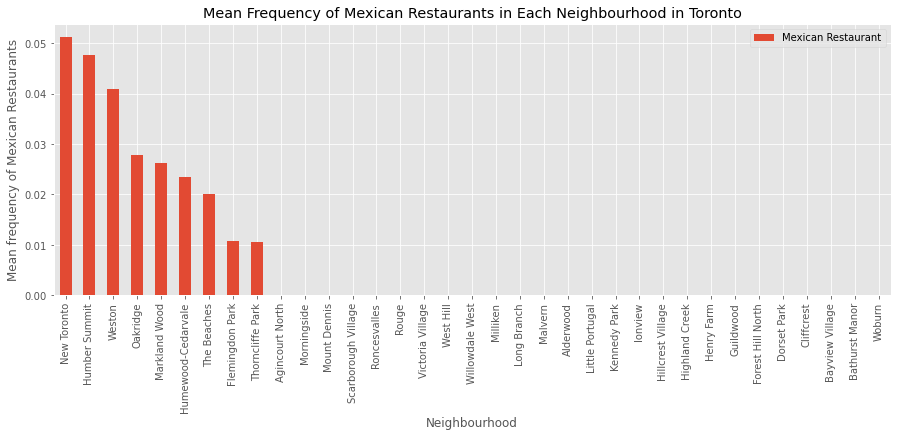

In [15]:
# sort by descending order
toronto_grouped.sort_values(by='Mexican Restaurant', ascending=False, inplace=True)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot')
toronto_grouped.plot(kind='bar', figsize=(15,5))

plt.title('Mean Frequency of Mexican Restaurants in Each Neighbourhood in Toronto')
plt.xlabel('Neighbourhood')
plt.ylabel('Mean frequency of Mexican Restaurants')

plt.show()

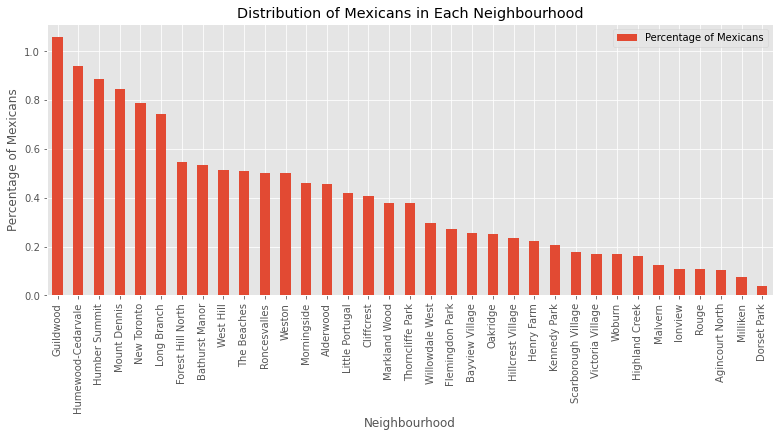

In [16]:
df_ethnic = df[['Neighbourhood', 'Percentage of Mexicans']].set_index('Neighbourhood')

# sort by descending order
df_ethnic.sort_values(by='Percentage of Mexicans', ascending=False, inplace=True)

#plot bar graph
df_ethnic.plot(kind='bar', figsize=(13,5))
plt.title('Distribution of Mexicans in Each Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Percentage of Mexicans')

plt.show()

## Plotting a bar graph to illustrate the distribution of income groups in each neighbourhood

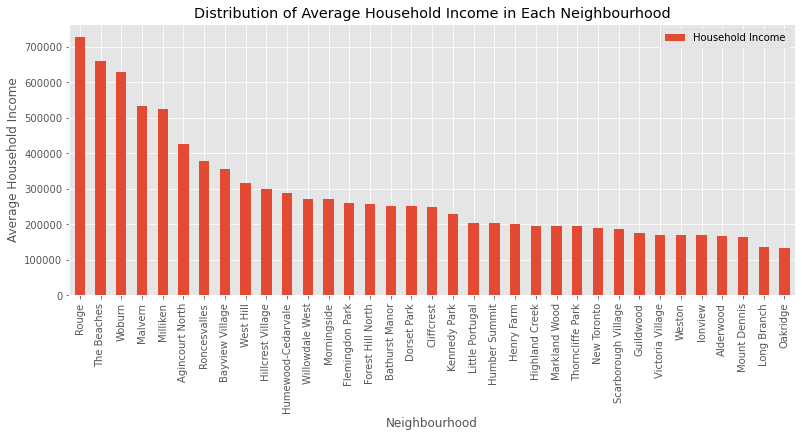

In [17]:
df_income = df[['Neighbourhood', 'Household Income']].set_index('Neighbourhood')

# sort by descending order
df_income.sort_values(by='Household Income', ascending=False, inplace=True)

#plot bar graph
df_income.plot(kind='bar', figsize=(13,5))
plt.title('Distribution of Average Household Income in Each Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Average Household Income')

plt.show()

## Finalise the dataframe for clustering

In [18]:
# merge df with toronto_grouped
df_final = pd.merge(df, toronto_grouped, on='Neighbourhood')

In [19]:
df_final.head()

,Neighbourhood,Latitude,Longitude,Household Income,Percentage of Mexicans,Mexican Restaurant
0,Victoria Village,43.725882,-79.315572,171271,0.171331,0.000000
1,Rouge,43.806686,-79.194353,729154,0.107536,0.000000
2,Malvern,43.806686,-79.194353,533202,0.125588,0.000000
3,Highland Creek,43.784535,-79.160497,196620,0.160077,0.000000
4,Flemingdon Park,43.725900,-79.340923,261233,0.273560,0.010753


## Cluster Neighbourhoods

# Normalizing over the standard deviation
Now let's normalize the dataset. But why do we need normalization in the first place? Normalization is a statistical method that helps mathematical-based algorithms to interpret features with different magnitudes and distributions equally. We use StandardScaler() to normalize our dataset.

In [20]:
from sklearn.preprocessing import StandardScaler
X = df_final.values[:,3:]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

array([[-0.76423265, -0.84496112, -0.51176035],
       [ 2.91459439, -1.08536401, -0.51176035],
       [ 1.62243543, -1.01733755, -0.51176035],
       [-0.59707469, -0.88736998, -0.51176035],
       [-0.17099959, -0.45971933,  0.23295554],
       [ 0.01810408,  2.05087396,  1.11785324],
       [-0.60504056, -0.06236927,  1.3108338 ],
       [-0.72604528,  2.49932685, -0.51176035],
       [-0.09447977,  0.2365328 , -0.51176035],
       [ 0.19509409,  0.43541629, -0.51176035],
       [ 2.45324659,  0.43142312,  0.8734112 ],
       [ 2.25435044, -0.85648935, -0.51176035],
       [ 0.07617315, -0.60046586, -0.51176035],
       [-0.23463423,  0.52737414, -0.51176035],
       [-0.60700565, -0.06236927,  0.21727731],
       [-0.66732337, -0.81461705, -0.51176035],
       [-0.5592434 , -0.65174369, -0.51176035],
       [-0.55558359,  0.08369899, -0.51176035],
       [-0.77890489, -1.07622008, -0.51176035],
       [-0.3809807 , -0.72032993, -0.51176035],
       [ 0.44662564, -0.5219091 , -0.511

In [21]:
df_normalized = pd.DataFrame(Clus_dataSet)
df_normalized.rename(columns={0:'Household Income', 1:'% Mexican Population', 2:'No. of Mexican Restaurants'}, inplace=True)
df_normalized.head()

,Household Income,% Mexican Population,No. of Mexican Restaurants
0,-0.764233,-0.844961,-0.511760
1,2.914594,-1.085364,-0.511760
2,1.622435,-1.017338,-0.511760
3,-0.597075,-0.887370,-0.511760
4,-0.171000,-0.459719,0.232956


## Finding the optimal number of clusters, k
So, how can we choose right value for K? The general solution is to reserve a part of your data for testing the accuracy of the model. Then chose k =1, use the training part for modeling, and calculate the accuracy of prediction using all samples in your test set. Repeat this process, increasing the k, and see which k is the best for your model.

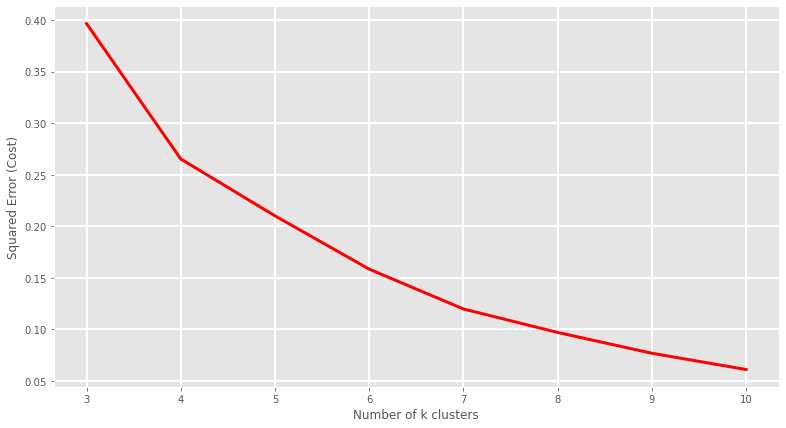

In [22]:
from sklearn.cluster import KMeans

error_cost=[]

for i in range(3, 11):
  KM = KMeans(n_clusters=i, max_iter=100)
  try:
    KM.fit(df_normalized)

  except ValueError:
    print('Error on line', i)

  # calculate squared error for the clustered points
  error_cost.append(KM.inertia_ / 100)

# plot the K values against the squared error cost
plt.figure(figsize=(13,7))
plt.plot(range(3,11), error_cost, color='r', linewidth=3)
plt.xlabel('Number of k clusters')
plt.ylabel('Squared Error (Cost)')
plt.grid(color='white', linestyle='-', linewidth=2)

plt.show()

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python-3.7-main

  added / updated specs:
    - yellowbrick


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pytest-runner-5.2          |     pyhd3eb1b0_0           9 KB
    yellowbrick-1.2            |           py37_0         284 KB  districtdatalabs
    ------------------------------------------------------------
                                           Total:         293 KB

The following NEW packages will be INSTALLED:

  pytest-runner      pkgs/main/noarch::pytest-runner-5.2-pyhd3eb1b0_0
  yellowbrick        districtdatalabs/linux-64::yellowbrick-1.2-py37_0



pytest-runner-5.2    | 9 KB      | ##################################### | 100% 
yellowbrick-1.2      | 284 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transacti

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f3ff8637f10>,
                 k=None, model=None)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


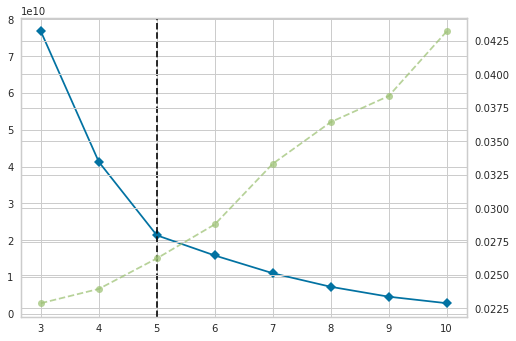

In [23]:
!conda install -c districtdatalabs yellowbrick 

from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,11))

visualizer.fit(X)
visualizer

After analysing using elbow method using distortion score & Squared error for each K value, looks like K = 5 is the best value.

## Clustering the Toronto Neighborhood Using K-Means with K = 5

In [24]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_normalized)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 2, 2, 1, 1, 3, 4, 3, 1, 1], dtype=int32)

Create a new dataframe that includes the cluster.

In [25]:
df_normalized.drop(['Household Income', '% Mexican Population'], axis=1, inplace=True)
df_clustered = pd.merge(df, df_normalized, left_index=True, right_index=True)
df_clustered.insert(0, 'Cluster Label', kmeans.labels_)

## Visulize the clusters on a map

In [26]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude,longitude], zoom_start=11)

# set color schemes for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_clustered['Latitude'], df_clustered['Longitude'], df_clustered['Neighbourhood'], df_clustered['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine clusters

## Cluster 0

In [27]:
df_clustered.loc[df_clustered['Cluster Label'] == 0]

,Cluster Label,Neighbourhood,Latitude,Longitude,Household Income,Percentage of Mexicans,No. of Mexican Restaurants
22,0,Humber Summit,43.756303,-79.565963,202677,0.885954,2.786267
32,0,New Toronto,43.605647,-79.501321,188819,0.785135,3.039962


## Cluster 1

In [28]:
df_clustered.loc[df_clustered['Cluster Label'] == 1]

,Cluster Label,Neighbourhood,Latitude,Longitude,Household Income,Percentage of Mexicans,No. of Mexican Restaurants
0,1,Victoria Village,43.725882,-79.315572,171271,0.171331,-0.511760
3,1,Highland Creek,43.784535,-79.160497,196620,0.160077,-0.511760
4,1,Flemingdon Park,43.725900,-79.340923,261233,0.273560,0.232956
8,1,Morningside,43.763573,-79.188711,272837,0.458321,-0.511760
9,1,West Hill,43.763573,-79.188711,316750,0.511098,-0.511760
12,1,Hillcrest Village,43.803762,-79.363452,298716,0.236211,-0.511760
13,1,Bathurst Manor,43.754328,-79.442259,251583,0.535501,-0.511760
14,1,Thorncliffe Park,43.705369,-79.349372,195114,0.379003,0.217277
15,1,Scarborough Village,43.744734,-79.239476,185967,0.179383,-0.511760
16,1,Henry Farm,43.778517,-79.346556,202357,0.222604,-0.511760


## Cluster 2

In [29]:
df_clustered.loc[df_clustered['Cluster Label'] == 2]

,Cluster Label,Neighbourhood,Latitude,Longitude,Household Income,Percentage of Mexicans,No. of Mexican Restaurants
1,2,Rouge,43.806686,-79.194353,729154,0.107536,-0.511760
2,2,Malvern,43.806686,-79.194353,533202,0.125588,-0.511760
10,2,The Beaches,43.676357,-79.293031,659192,0.510038,0.873411
11,2,Woburn,43.770992,-79.216917,629030,0.168271,-0.511760
30,2,Agincourt North,43.815252,-79.284577,427037,0.103047,-0.511760
31,2,Milliken,43.815252,-79.284577,525507,0.075267,-0.511760


## Cluster 3

In [30]:
df_clustered.loc[df_clustered['Cluster Label'] == 3]

,Cluster Label,Neighbourhood,Latitude,Longitude,Household Income,Percentage of Mexicans,No. of Mexican Restaurants
5,3,Humewood-Cedarvale,43.693781,-79.428191,289910,0.939784,1.117853
7,3,Guildwood,43.763573,-79.188711,177062,1.058788,-0.511760
24,3,Mount Dennis,43.691116,-79.476013,164344,0.846024,-0.511760
34,3,Long Branch,43.602414,-79.543484,137480,0.743752,-0.511760


## Cluster 4

In [31]:
df_clustered.loc[df_clustered['Cluster Label'] == 4]

,Cluster Label,Neighbourhood,Latitude,Longitude,Household Income,Percentage of Mexicans,No. of Mexican Restaurants
6,4,Markland Wood,43.643515,-79.577201,195412,0.379003,1.310834
21,4,Oakridge,43.711112,-79.284577,134303,0.252799,1.412089
25,4,Weston,43.706876,-79.518188,171044,0.500222,2.315120
